In [1]:
import prepare_data
import json
import networkx as nx
from collections import Counter

In [14]:
import json

# Filenames
file1 = "tweets_climatechange_20251112_141744.json"
file2 = "tweets_climatechange_20251118_101004.json"
file3 = "tweets_climatechange_20251118_120651-16-17.json"
out_file = "tweets_climatechange_combined.json"

# Load first file
with open(file1, "r") as f:
    raw1 = json.load(f)
print(f"{file1} loaded as type: {type(raw1)}, tweets: {len(raw1)}")

# Load second file
with open(file2, "r") as f:
    raw2 = json.load(f)
print(f"{file2} loaded as type: {type(raw2)}, tweets: {len(raw2)}")

# Load third file
with open(file3, "r") as f:
    raw3 = json.load(f)
print(f"{file3} loaded as type: {type(raw3)}, tweets: {len(raw3)}")

# Combine into one list of tweets
combined = raw1 + raw2 + raw3
print("Total tweets in combined dataset:", len(combined))

# Save combined file (you can choose combined or deduped)
with open(out_file, "w") as f:
    json.dump(combined, f, indent=2)

print("Combined data written to:", out_file)


tweets_climatechange_20251112_141744.json loaded as type: <class 'list'>, tweets: 100
tweets_climatechange_20251118_101004.json loaded as type: <class 'list'>, tweets: 200
tweets_climatechange_20251118_120651-16-17.json loaded as type: <class 'list'>, tweets: 100
Total tweets in combined dataset: 400
Combined data written to: tweets_climatechange_combined.json


In [15]:
tweets_data = [prepare_data.extract_tweet(t) for t in combined]

G = nx.DiGraph()

for tw in tweets_data:
    author = tw["author_id"]               # always present
    mention_ids = tw["mention_ids"]        # list of IDs

    for target in mention_ids:
        if target is None:
            continue
        G.add_edge(author, target)

print("Nodes: ", G.number_of_nodes())
print("Edges: ", G.number_of_edges())

Nodes:  569
Edges:  447


In [16]:
# In-degree: how many times each user is mentioned
in_deg = dict(G.in_degree())

# Out-degree: how many mentions each user makes
out_deg = dict(G.out_degree())

nx.set_node_attributes(G, in_deg, "in_degree")
nx.set_node_attributes(G, out_deg, "out_degree")

# Count how many tweets each author_id has
author_counts = Counter(tw["author_id"] for tw in tweets_data)

# Map to all nodes (0 if they never authored a tweet in this sample)
n_tweets = {node: author_counts.get(node, 0) for node in G.nodes()}
nx.set_node_attributes(G, n_tweets, "n_tweets")

# Aggregate retweets per author
retweets_per_author = Counter()

for tw in tweets_data:
    author = tw["author_id"]
    rt = tw.get("retweets", 0)   # this came from public_metrics in extract_tweet
    if author is not None and rt is not None:
        retweets_per_author[author] += rt

# Map to all nodes in G (0 if they never authored a tweet)
total_retweets_attr = {node: retweets_per_author.get(node, 0) for node in G.nodes()}

# Store as node attribute
nx.set_node_attributes(G, total_retweets_attr, "total_retweets")


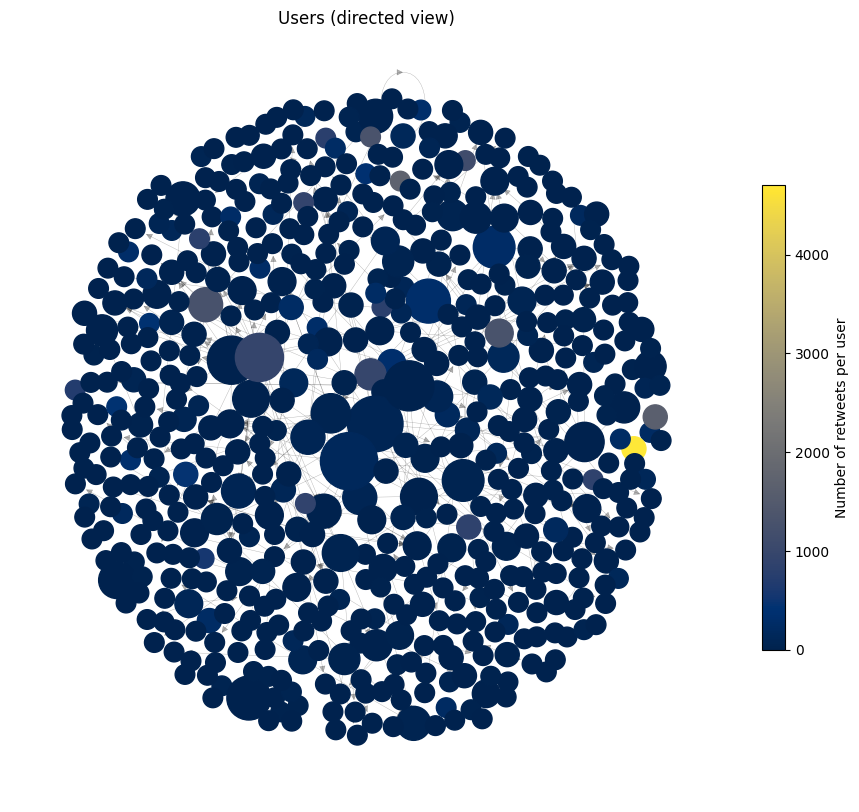

In [17]:
import numpy as np
import matplotlib.pyplot as plt

UG = G.to_undirected()

deg = dict(UG.degree())
node_sizes = [100 + 100*deg[n] for n in UG.nodes()]  # tweak for better visualization

content = np.array([G.nodes[n].get("total_retweets", 0) for n in G.nodes()]) # node color by content_length attribute

pos = nx.forceatlas2_layout(G, max_iter=500, gravity=0.8, scaling_ratio=2.0, seed=123, distributed_action=False, strong_gravity=True)

plt.figure(figsize=(10, 10))
nx.draw_networkx_edges(G, pos, width=0.3, alpha=0.3)
nodes = nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color=content,
    cmap="cividis",               # sequential colormap
    vmin=content.min(),
    vmax=content.max()
)
plt.colorbar(nodes, label="Number of retweets per user", ax=plt.gca(), fraction=0.03)
plt.axis('off')
plt.title("Users (directed view)")
plt.show()

In [18]:
# Print the text of the most retweeted tweet
most_retweeted = max(tweets_data, key=lambda x: x.get("retweets", 0))
print("Most retweeted tweet ({} retweets):".format(most_retweeted.get("retweets", 0)))
print(most_retweeted["text"])

Most retweeted tweet (4710 retweets):
🚨 BREAKING: White House Press Secretary @KarolineLeavitt ORDERS Gavin “NEWSCUM” to leave the Brazilian Rainforest and GET BACK TO HIS STATE 🚨

“So maybe he should leave Brazil, stop lecturing the world about climate change, and start fixing what was once a beautiful state” 🔥 https://t.co/XxseZ7qTvw


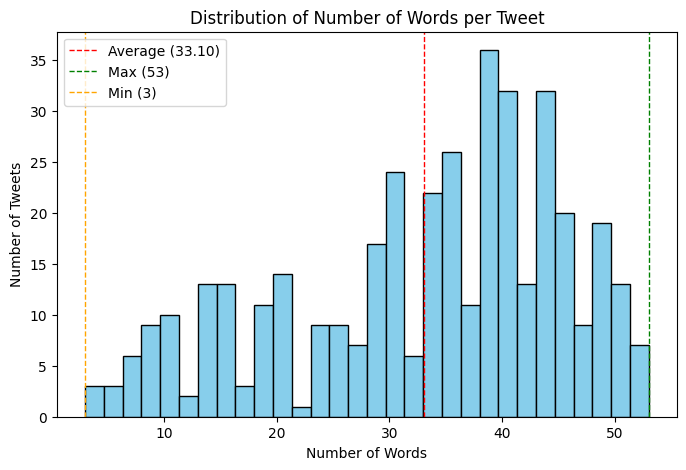

In [19]:
# Compute statistics of number of words in tweets
word_counts = [len(tw["text"].split()) for tw in tweets_data]
avg_words = np.mean(word_counts)
max_words = np.max(word_counts)
min_words = np.min(word_counts)

# Make a histogram including statistics
plt.figure(figsize=(8, 5))
plt.hist(word_counts, bins=30, color='skyblue', edgecolor='black')
plt.axvline(avg_words, color='red', linestyle='dashed', linewidth=1, label='Average ({:.2f})'.format(avg_words))
plt.axvline(max_words, color='green', linestyle='dashed', linewidth=1, label='Max ({})'.format(max_words))
plt.axvline(min_words, color='orange', linestyle='dashed', linewidth=1, label='Min ({})'.format(min_words))
plt.title("Distribution of Number of Words per Tweet")
plt.xlabel("Number of Words")
plt.ylabel("Number of Tweets")
plt.legend()
plt.show()

# Detect emotions of tweets

In [20]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

MODEL = "cardiffnlp/twitter-roberta-base-emotion"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# model returns logits for these labels:
EMOTION_LABELS = ["anger", "disgust", "fear", "joy", "sadness", "surprise"]

In [21]:
def get_emotion(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return None, None

    # tokenize
    inputs = tokenizer(text, return_tensors="pt", truncation=True)

    # get model output
    with torch.no_grad():
        logits = model(**inputs).logits

    # softmax for probabilities
    probs = torch.softmax(logits, dim=1).numpy()[0]

    # get top emotion
    top_idx = np.argmax(probs)
    top_emotion = EMOTION_LABELS[top_idx]

    return top_emotion, dict(zip(EMOTION_LABELS, probs))

In [22]:
for tw in tweets_data:
    emotion, prob_dict = get_emotion(tw["text"])
    tw["emotion"] = emotion
    tw["emotion_probs"] = prob_dict

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [23]:
from collections import defaultdict

user_emotions = defaultdict(list)

# collect emotion per tweet
for tw in tweets_data:
    if tw["emotion"] is not None:
        user_emotions[tw["author_id"]].append(tw["emotion"])

# pick dominant emotion per user
dominant_user_emotion = {
    user: max(set(emolist), key=emolist.count)
    for user, emolist in user_emotions.items()
}

# attach as node attribute
nx.set_node_attributes(G, dominant_user_emotion, "user_emotion")

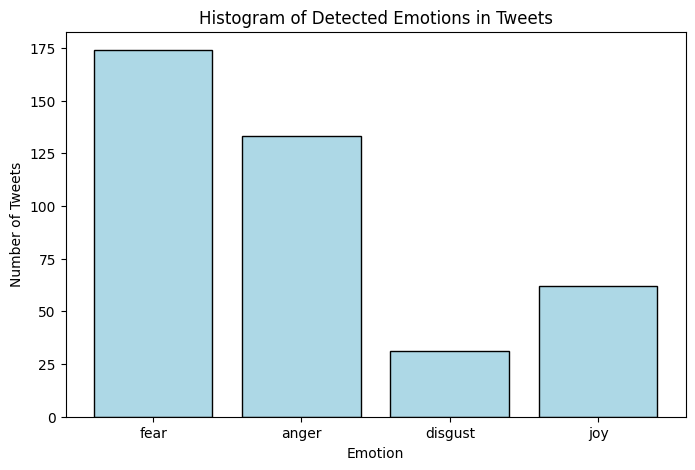

In [24]:
# Histogram of all emotions detected in tweets
all_emotions = [tw["emotion"] for tw in tweets_data if tw["emotion"] is not None]
emotion_counts = Counter(all_emotions)
plt.figure(figsize=(8, 5))
plt.bar(emotion_counts.keys(), emotion_counts.values(), color='lightblue', edgecolor='black')
plt.title("Histogram of Detected Emotions in Tweets")
plt.xlabel("Emotion")
plt.ylabel("Number of Tweets")
plt.show()

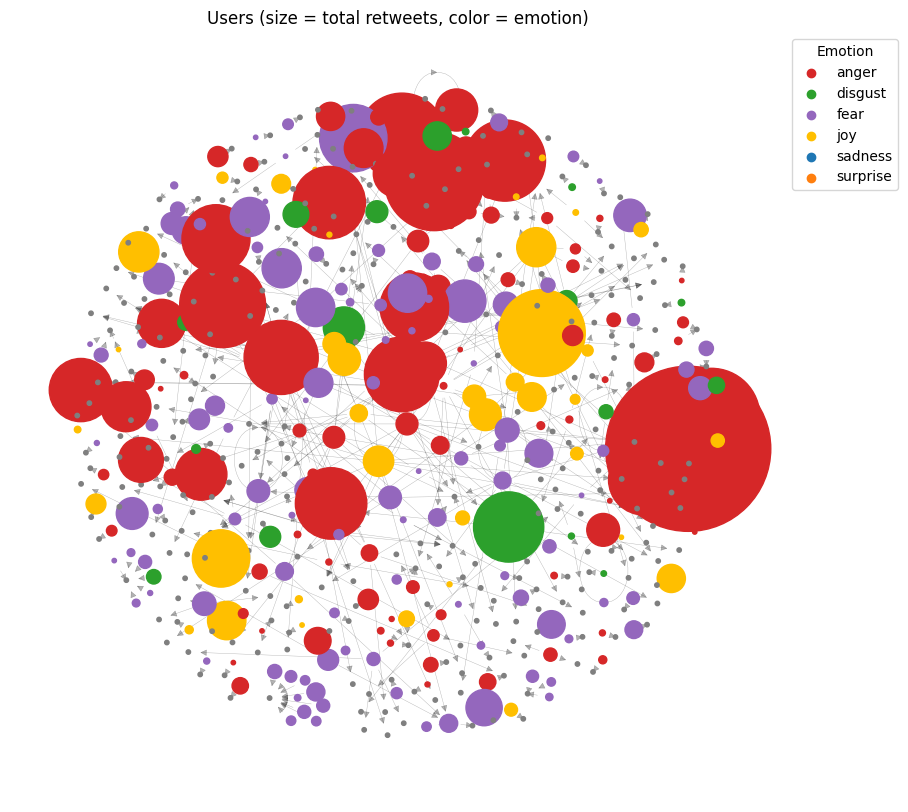

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Emotion labels used by your model
EMOTIONS = ["anger", "disgust", "fear", "joy", "sadness", "surprise"]

# Pick a distinct color for each emotion
emotion_colors = {
    "anger":    "#d62728",  # red
    "disgust":  "#2ca02c",  # green
    "fear":     "#9467bd",  # purple
    "joy":      "#ffbf00",  # yellow-orange
    "sadness":  "#1f77b4",  # blue
    "surprise": "#ff7f0e",  # orange
    None:       "#7f7f7f"   # gray for missing
}

# Node colors: based on dominant emotion
node_colors = [
    emotion_colors.get(G.nodes[n].get("user_emotion"), "#7f7f7f")
    for n in G.nodes()
]

# Node sizes: based on total number of retweets
# assumes you already set G.nodes[n]["total_retweets"]
total_retweets = np.array([G.nodes[n].get("total_retweets", 0) for n in G.nodes()])

# simple scaling: base size + factor * retweets
node_sizes = 10 + 3 * total_retweets

# layout
pos = nx.forceatlas2_layout(
    G,
    max_iter=500,
    gravity=0.8,
    scaling_ratio=2.0,
    seed=123,
    distributed_action=False,
    strong_gravity=True
)

plt.figure(figsize=(10, 10))

# edges
nx.draw_networkx_edges(G, pos, width=0.3, alpha=0.3)

# nodes
nodes = nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color=node_colors
)

plt.axis("off")
plt.title("Users (size = total retweets, color = emotion)")

# manual legend for emotions
for emotion, color in emotion_colors.items():
    plt.scatter([], [], c=color, label=emotion)

plt.legend(
    title="Emotion",
    loc="upper left",
    bbox_to_anchor=(1, 1)
)

plt.show()